<a href="https://colab.research.google.com/github/pankaj90382/TSAI/blob/master/S7/S7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !rm -r /content/Dataset/
# !rm -r /content/tensorboard/

In [2]:
!nvidia-smi

Thu Jul 30 16:13:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#load dataset into the colab
path='/content/drive/My Drive/TSAI/Session 2 Dataset'
# Extracting the data by 7zipper
!7z x '{path}'.7z -o'/content/Dataset'

In [6]:
!mv '/content/Dataset/Session 2 Dataset/FlyBirds Canada'/* '/content/Dataset/Session 2 Dataset/Flying Birds/' 

In [7]:
!rm -d '/content/Dataset/Session 2 Dataset/FlyBirds Canada'

In [8]:
import sys
S2_PROJECT_PATH = '/content/drive/My Drive/TSAI/TSAI-2/S2'
sys.path.append(S2_PROJECT_PATH+'/S2_Modular_Code/')
import os
os.chdir(S2_PROJECT_PATH+'/S2_Modular_Code/')

In [9]:
from __future__ import print_function
import torch
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
#!pip install torchsummary
from torchsummary import summary
import pandas as pd
import numpy as np
from utils import *
from torch.utils.tensorboard import SummaryWriter
import re

#Dataloader Arguments & Test/Train Dataloaders


In [10]:
from torchDataset import MyMobset
from PIL import Image
from matplotlib import pyplot as plt

In [11]:
from pathlib import Path
data_root=Path('/content/Dataset')

In [12]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"
from Album_Methods import Albumentations as AM

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-a3nt8qja
All libraries are successfully installed!


In [13]:
mean=(0.49641467, 0.50198746, 0.48275208)
std=(0.2798614 , 0.27848746, 0.31762387)

In [14]:
train_transform = AM().transform(**{
    'Normalize': {'mean': mean, 'std': std},
    'Resize':{'height':224, 'width':224},
    'ShiftScaleRotate' : {'shift_limit':0.0625, 'scale_limit':0.2, 'rotate_limit':(-10,10), 'p':.2},
    'RandomBrightnessContrast':{'brightness_limit':0.2, 'contrast_limit':0.2, 'brightness_by_max':False},
    'HueSaturationValue':{'hue_shift_limit':0.1, 'sat_shift_limit':0.1, 'val_shift_limit':0, 'p':0.2},
    'GridDistortion' : {'num_steps':5},
    'RandomRotate90' : {},
    #'ToGray':{'always_apply'=True},
    'ToTensor':{}
})

test_transform = AM().transform(**{
    'Normalize': {'mean': mean, 'std': std},
    'Resize':{'height':224, 'width':224},
    'ToTensor':{}
})

In [15]:
# pattern for reading filenames
pattern = re.compile(r'.?(.jpg|.jpeg)$',re.IGNORECASE)

# reading filenames
filenames = [ i for i in data_root.rglob('*') if pattern.match(i.suffix) and Image.open(i).mode=='RGB']
classeslabels = list(map(lambda x: x.parent.name, filenames))

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [16]:
# label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(classeslabels)

In [17]:
from DataLoader import DataLoader

SEED = 1

# Splitting Dataset into train and test
from sklearn.model_selection import train_test_split
trainimages,testimages,trainlabels, testlabels = train_test_split(filenames, labels, train_size=0.90, test_size=0.10, shuffle=True)

# Downloading TrainSet
trainset = MyMobset(trainimages, trainlabels, transform=train_transform)

# Downloading Testset
testset = MyMobset(testimages, testlabels, transform=test_transform)

# Creating object of a class
dataloader= DataLoader(shuffle=False, batch_size=40, seed=SEED, num_workers=2, pin_memory=True)


# split trainset data according to S2 Requirements
#trainset,testset = torch.utils.data.random_split(trainset, [int(.70*len(trainset)), int(.30*len(trainset))]) 

# train data loader
trainloader = dataloader.load(trainset)

# test data loader
testloader = dataloader.load(testset)

CUDA Available? True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([40, 3, 224, 224]) tensor([0.3012, 0.4187, 0.4964]) tensor([0.7116, 0.6511, 0.7136])
Winged Drones Flying Birds Flying Birds Flying Birds Flying Birds Flying Birds Winged Drones Small QuadCopters Flying Birds Winged Drones Large QuadCopters Flying Birds Flying Birds Small QuadCopters Large QuadCopters Flying Birds Flying Birds Flying Birds Large QuadCopters Small QuadCopters Large QuadCopters Small QuadCopters Small QuadCopters Large QuadCopters Flying Birds Winged Drones Winged Drones Large QuadCopters Flying Birds Winged Drones Winged Drones Winged Drones Large QuadCopters Flying Birds Winged Drones Winged Drones Flying Birds Flying Birds Large QuadCopters Flying Birds


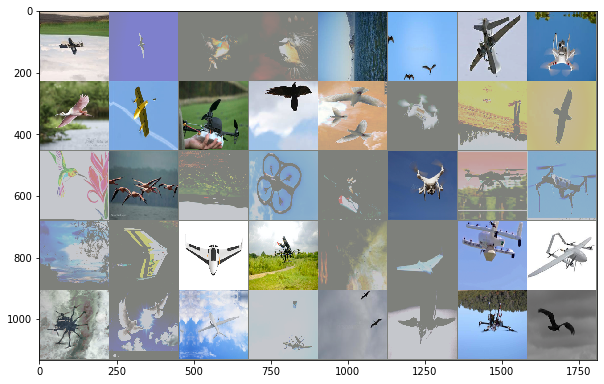

In [18]:
sample_images(trainloader, mean, std, le.classes_, count=40)

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


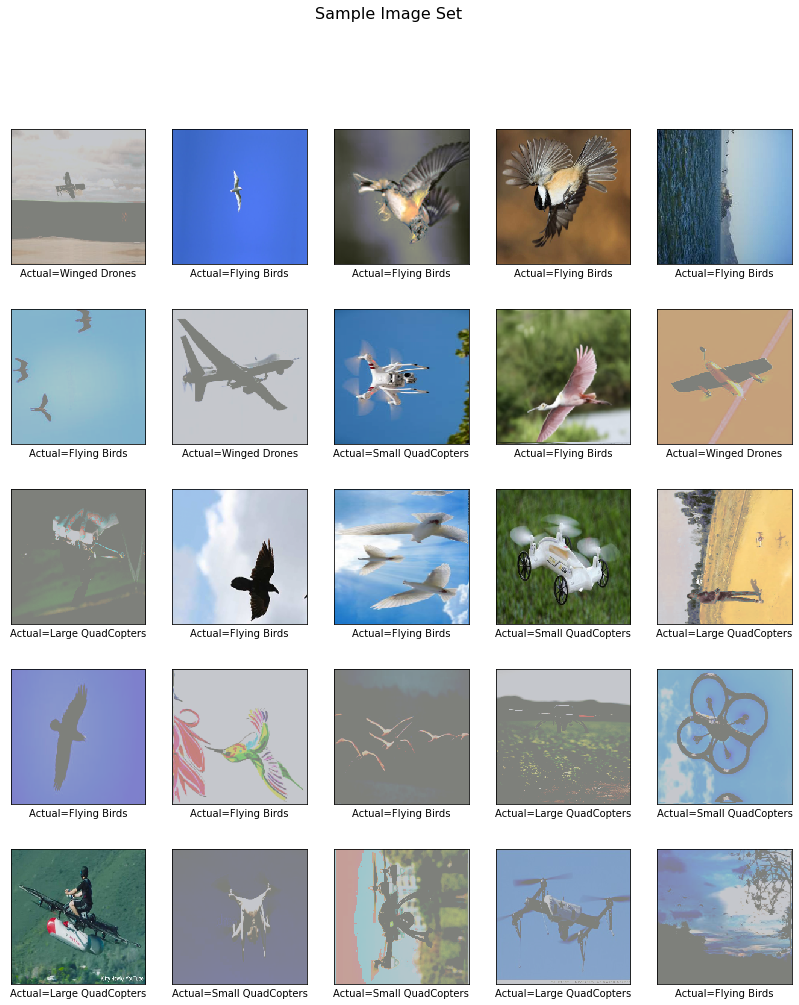

In [19]:
sample_images(trainloader, mean, std, le.classes_, count=25, LabelClarity=True)

In [20]:
# # default `log_dir` is "runs" - we'll be more specific here
# writer = SummaryWriter('/content/tensorboard/'+name)

In [21]:
# # Look at training curves in tensorboard:
# %load_ext tensorboard
# %tensorboard --logdir '/content/tensorboard/{name}'

Let us show some of the training images, for fun.



2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [22]:
name = 'mobilenet_v2'
#load mobilenetv2 code
model = torch.hub.load('pytorch/vision:v0.6.0', name, pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [23]:
# Checking the layers of mobilenetv2
for name, param in model.named_parameters():
   print(name)

features.0.0.weight
features.0.1.weight
features.0.1.bias
features.1.conv.0.0.weight
features.1.conv.0.1.weight
features.1.conv.0.1.bias
features.1.conv.1.weight
features.1.conv.2.weight
features.1.conv.2.bias
features.2.conv.0.0.weight
features.2.conv.0.1.weight
features.2.conv.0.1.bias
features.2.conv.1.0.weight
features.2.conv.1.1.weight
features.2.conv.1.1.bias
features.2.conv.2.weight
features.2.conv.3.weight
features.2.conv.3.bias
features.3.conv.0.0.weight
features.3.conv.0.1.weight
features.3.conv.0.1.bias
features.3.conv.1.0.weight
features.3.conv.1.1.weight
features.3.conv.1.1.bias
features.3.conv.2.weight
features.3.conv.3.weight
features.3.conv.3.bias
features.4.conv.0.0.weight
features.4.conv.0.1.weight
features.4.conv.0.1.bias
features.4.conv.1.0.weight
features.4.conv.1.1.weight
features.4.conv.1.1.bias
features.4.conv.2.weight
features.4.conv.3.weight
features.4.conv.3.bias
features.5.conv.0.0.weight
features.5.conv.0.1.weight
features.5.conv.0.1.bias
features.5.conv.1.

In [24]:
# freezing the other layers
for param in model.parameters():
    param.requires_grad = False

In [25]:
# checking the last layer
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [26]:
num_ftrs = model.classifier[1].in_features

In [27]:
# Replacing the last layer
num_classes = 4
model.classifier[1] = nn.Linear(num_ftrs, num_classes, bias=True)

In [28]:
# updated last layer
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=4, bias=True)
)

In [29]:
# Assigning to the model Trainer
import torch.nn as nn
import torch.nn.functional as F
from ModelTransfer import *
# loading the model
model.to(dataloader.device)
model.device=dataloader.device
model.name=name
model = Net(model)
# model summary
model.summary(input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [30]:
torch.cuda.empty_cache()

In [31]:
# # ...log a Matplotlib Figure showing the model's predictions on a
#             # random mini-batch
# writer.add_figure('Epoch Images', plot_classes_preds(net, inputs, labels), global_step=epoch * len(trainloader) + i)

In [32]:
import copy
modelbeforetrain = copy.deepcopy(model.getmodel().state_dict())

In [33]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
#from LRFinder import LR_Finder
Loss="CrossEntropyLoss"
EPOCHS = 5
model.device=dataloader.device
optimizer = optim.SGD(model.getmodel().classifier[1].parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)
#lrfinder = LR_Finder(optimizer)
#optimizer, scheduler = lrfinder.range_test(start_lr=1e-2, end_lr=3,num_iter=1000, step_mode="exp", smooth_f=0.05, diverge_th=5)
scheduler=StepLR(optimizer,step_size=5,gamma=0.1)
model.gotrain(optimizer=optimizer, train_loader=trainloader, test_loader=testloader, dataloader=dataloader, epochs=EPOCHS, statspath=S2_PROJECT_PATH+"/Save_Model/", scheduler=scheduler, batch_scheduler=None, L1lambda=0, LossType=Loss, tb=None)

Batch=59 Loss=0.9079 Acc=58.94%:  15%|█▍        | 58/397 [00:25<02:48,  2.01it/s]/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
  0%|          | 0/397 [00:00<?, ?it/s]

Validation loss decreased (100000.000000 --> 0.338645).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0234, Accuracy: 65.67%; Test set: Average loss: 0.3386, Accuracy: 78.41%
Learning Rate = 0.010000


Batch=456 Loss=1.6101 Acc=66.40%:  15%|█▍        | 58/397 [00:25<02:42,  2.09it/s]/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
  0%|          | 0/397 [00:00<?, ?it/s]

Epoch: 2, Train set: Average loss: 0.0233, Accuracy: 67.32%; Test set: Average loss: 0.3917, Accuracy: 75.35%
Learning Rate = 0.010000


Batch=853 Loss=1.1591 Acc=67.25%:  15%|█▍        | 58/397 [00:25<02:42,  2.08it/s]/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
  0%|          | 0/397 [00:00<?, ?it/s]

Epoch: 3, Train set: Average loss: 0.0234, Accuracy: 67.74%; Test set: Average loss: 0.3486, Accuracy: 79.15%
Learning Rate = 0.010000


Batch=1250 Loss=1.0345 Acc=67.42%:  15%|█▍        | 58/397 [00:25<02:42,  2.08it/s]/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
  0%|          | 0/397 [00:00<?, ?it/s]

Validation loss decreased (0.338645 --> 0.311935).  Saving model ...
Epoch: 4, Train set: Average loss: 0.0232, Accuracy: 67.84%; Test set: Average loss: 0.3119, Accuracy: 80.79%
Learning Rate = 0.010000


Batch=1647 Loss=1.0685 Acc=67.50%:  15%|█▍        | 58/397 [00:25<02:43,  2.07it/s]/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
Batch=1985 Loss=0.9191 Acc=68.15%: 100%|██████████| 397/397 [03:03<00:00,  2.17it/s]


Epoch: 5, Train set: Average loss: 0.0229, Accuracy: 68.15%; Test set: Average loss: 0.3577, Accuracy: 78.87%
Learning Rate = 0.010000



In [34]:
modelaftertrain = copy.deepcopy(model.getmodel().state_dict())

In [35]:
model.resumerun(10)

Batch=2044 Loss=1.1141 Acc=69.41%:  15%|█▍        | 58/397 [00:25<02:45,  2.05it/s]/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
  0%|          | 0/397 [00:00<?, ?it/s]

Validation loss decreased (0.311935 --> 0.284365).  Saving model ...
Epoch: 6, Train set: Average loss: 0.0189, Accuracy: 71.28%; Test set: Average loss: 0.2844, Accuracy: 81.25%
Learning Rate = 0.001000


Batch=2441 Loss=0.7201 Acc=70.93%:  15%|█▍        | 58/397 [00:25<02:47,  2.03it/s]/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
  0%|          | 0/397 [00:00<?, ?it/s]

Validation loss decreased (0.284365 --> 0.277996).  Saving model ...
Epoch: 7, Train set: Average loss: 0.0179, Accuracy: 72.35%; Test set: Average loss: 0.2780, Accuracy: 81.53%
Learning Rate = 0.001000


Batch=2838 Loss=0.8410 Acc=71.10%:  15%|█▍        | 58/397 [00:25<02:41,  2.09it/s]/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
  0%|          | 0/397 [00:00<?, ?it/s]

Validation loss decreased (0.277996 --> 0.274530).  Saving model ...
Epoch: 8, Train set: Average loss: 0.0177, Accuracy: 72.25%; Test set: Average loss: 0.2745, Accuracy: 82.15%
Learning Rate = 0.001000


Batch=3235 Loss=0.7955 Acc=71.53%:  15%|█▍        | 58/397 [00:25<02:46,  2.04it/s]/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
  0%|          | 0/397 [00:00<?, ?it/s]

Validation loss decreased (0.274530 --> 0.273854).  Saving model ...
Epoch: 9, Train set: Average loss: 0.0172, Accuracy: 72.84%; Test set: Average loss: 0.2739, Accuracy: 81.76%
Learning Rate = 0.001000


Batch=3632 Loss=0.6681 Acc=72.12%:  15%|█▍        | 58/397 [00:25<02:45,  2.05it/s]/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
  0%|          | 0/397 [00:00<?, ?it/s]

Validation loss decreased (0.273854 --> 0.270194).  Saving model ...
Epoch: 10, Train set: Average loss: 0.0171, Accuracy: 72.58%; Test set: Average loss: 0.2702, Accuracy: 81.42%
Learning Rate = 0.001000


Batch=4029 Loss=0.6162 Acc=71.95%:  15%|█▍        | 58/397 [00:25<02:45,  2.05it/s]/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
  0%|          | 0/397 [00:00<?, ?it/s]

Validation loss decreased (0.270194 --> 0.266228).  Saving model ...
Epoch: 11, Train set: Average loss: 0.0169, Accuracy: 73.22%; Test set: Average loss: 0.2662, Accuracy: 82.04%
Learning Rate = 0.000100


Batch=4426 Loss=0.8427 Acc=72.71%:  15%|█▍        | 58/397 [00:25<02:45,  2.05it/s]/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
  0%|          | 0/397 [00:00<?, ?it/s]

Epoch: 12, Train set: Average loss: 0.0169, Accuracy: 73.21%; Test set: Average loss: 0.2677, Accuracy: 82.21%
Learning Rate = 0.000100


Batch=4823 Loss=0.7808 Acc=72.63%:  15%|█▍        | 58/397 [00:25<02:46,  2.04it/s]/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
  0%|          | 0/397 [00:00<?, ?it/s]

Epoch: 13, Train set: Average loss: 0.0167, Accuracy: 73.12%; Test set: Average loss: 0.2669, Accuracy: 82.66%
Learning Rate = 0.000100


Batch=5220 Loss=0.8800 Acc=72.03%:  15%|█▍        | 58/397 [00:25<02:41,  2.10it/s]/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
  0%|          | 0/397 [00:00<?, ?it/s]

Validation loss decreased (0.266228 --> 0.265662).  Saving model ...
Epoch: 14, Train set: Average loss: 0.0167, Accuracy: 73.32%; Test set: Average loss: 0.2657, Accuracy: 82.61%
Learning Rate = 0.000100


Batch=5617 Loss=0.7472 Acc=72.80%:  15%|█▍        | 58/397 [00:25<02:45,  2.05it/s]/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
Batch=5955 Loss=0.7342 Acc=73.86%: 100%|██████████| 397/397 [03:02<00:00,  2.18it/s]


Validation loss decreased (0.265662 --> 0.264361).  Saving model ...
Epoch: 15, Train set: Average loss: 0.0164, Accuracy: 73.86%; Test set: Average loss: 0.2644, Accuracy: 82.21%
Learning Rate = 0.000100



In [36]:
#lrfinder.plot(load_path=S2_PROJECT_PATH+'/Save_Model/Model_Unet.json',cols=["batch_train_loss", "batch_val_loss"], ylabel='Loss', legend_arr=['Batch Train Loss', 'Batch Val Loss'], title='Complete_LR_Finder_Curve', save_path=S2_PROJECT_PATH+"/Save_Model/", skip_start=0, skip_end=0, log_lr=True)

In [37]:
#lrfinder.plot(load_path=S2_PROJECT_PATH+'/Save_Model/Model_LR_Finder_stats.json',cols=["batch_val_loss"], ylabel='Loss', legend_arr=['Batch Val Loss'], title='LR_Finder_Curve', save_path=S2_PROJECT_PATH+"/Save_Model/", skip_start=0, skip_end=2, log_lr=True)

In [38]:
#lrfinder.plot(load_path=S2_PROJECT_PATH+'/Save_Model/Model_LR_Finder_stats.json',cols=["batch_train_loss"], ylabel='Loss', legend_arr=['Batch Train Loss'], title='Train_LR_Finder_Curve', save_path=S2_PROJECT_PATH+"/Save_Model/", skip_start=2, skip_end=2, log_lr=True)

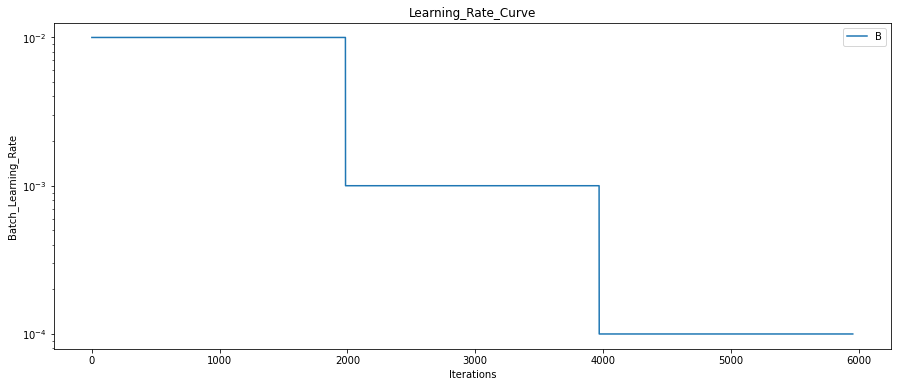

In [39]:
plot_graph(load_path=S2_PROJECT_PATH+'/Save_Model/'+name+'_stats.json', cols=["batch_lr"], legend_arr='Batch_Learning_Curve', xlabel='Iterations', ylabel='Batch_Learning_Rate', title='Learning_Rate_Curve', save_path=S2_PROJECT_PATH+'/Save_Model/',log=True)

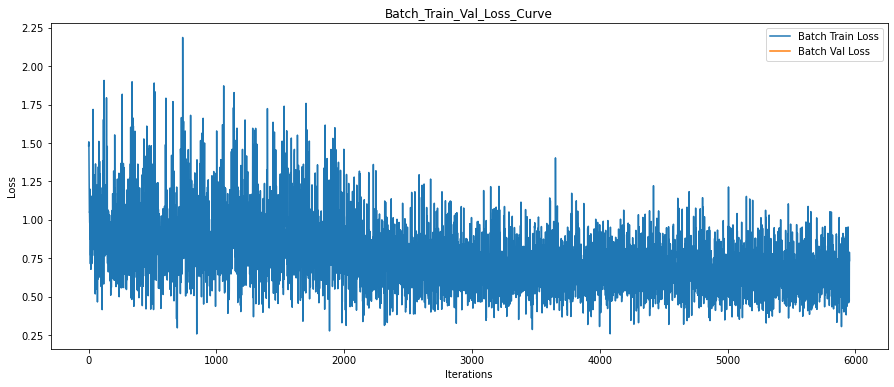

In [40]:
plot_graph(load_path=S2_PROJECT_PATH+'/Save_Model/'+name+'_stats.json', cols=["batch_train_loss", "batch_val_loss"], legend_arr=['Batch Train Loss', 'Batch Val Loss'], xlabel='Iterations', ylabel='Loss', title='Batch_Train_Val_Loss_Curve', save_path=S2_PROJECT_PATH+'/Save_Model/')

In [41]:
# from torch.optim.lr_scheduler import ReduceLROnPlateau
# model = Resnet_Architecture(Model_Layers=18, name="Model_Res", num_classes=200)
# model.to(dataloader.device)
# Loss="CrossEntropyLoss"
# EPOCHS = 30
# model.device=dataloader.device
# optimizer = optim.SGD(model.parameters(), lr=0.100174454672119, weight_decay=0.0019 ,momentum=0.9)
# #scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3, verbose=True, min_lr=1e-5)
# #scheduler=StepLR(optimizer,step_size=5,gamma=0.1)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.100174454672119, steps_per_epoch=len(trainloader), epochs=EPOCHS,  pct_start=5/EPOCHS, div_factor=100, final_div_factor=8)
# model.gotrain(optimizer=optimizer, train_loader=trainloader, test_loader=testloader, dataloader=dataloader, epochs=EPOCHS, statspath=S2_PROJECT_PATH+"/Save_Model/", scheduler=scheduler, batch_scheduler=True, L1lambda=0, LossType=Loss)

In [42]:
# Class Accuracy for testloader
class_acurracy(model.getmodel(), model.getmodel().device, testloader, le.classes_)

Accuracy of Flying Birds : 97 %
Accuracy of Large QuadCopters : 72 %
Accuracy of Small QuadCopters : 65 %
Accuracy of Winged Drones : 85 %


In [56]:
class_acurracy(model.getmodel(), model.getmodel().device, trainloader, le.classes_)

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Accuracy of Flying Birds : 93 %
Accuracy of Large QuadCopters : 62 %
Accuracy of Small QuadCopters : 66 %
Accuracy of Winged Drones : 77 %


In [43]:
MisClassifiedImages, MisClassifiedPredLabels, MisClassifiedTargLabels = get_classified_images(model.getmodel(), model.getmodel().device, testloader, classification='Miss')

In [44]:
CorrClassifiedImages, CorrClassifiedPredLabels, CorrClassifiedTargLabels = get_classified_images(model.getmodel(), model.getmodel().device, testloader, classification='Corr')

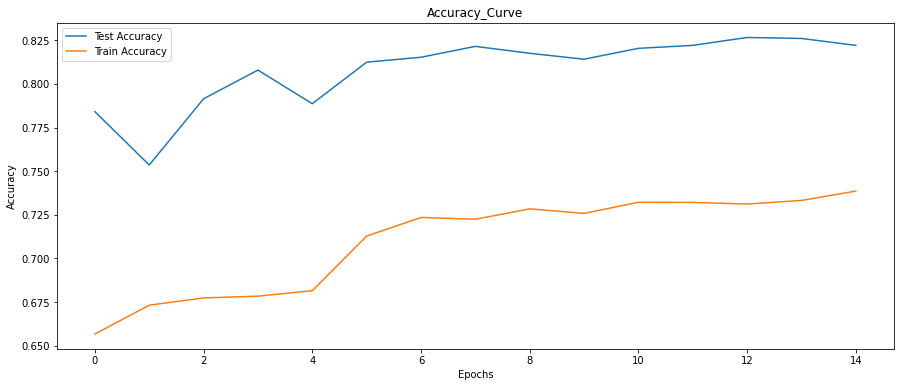

In [45]:
cols = ["batch_train_loss", "batch_train_acc", "batch_lr","avg_test_loss", "test_acc", "train_acc", "avg_train_loss", "lr", "best_test_loss", "epochs"]
plot_graph(load_path=S2_PROJECT_PATH+'/Save_Model/'+name+'_stats.json', cols=["test_acc", "train_acc"], legend_arr=['Test Accuracy', 'Train Accuracy'], xlabel='Epochs', ylabel='Accuracy', title='Accuracy_Curve', save_path=S2_PROJECT_PATH+'/Save_Model/')

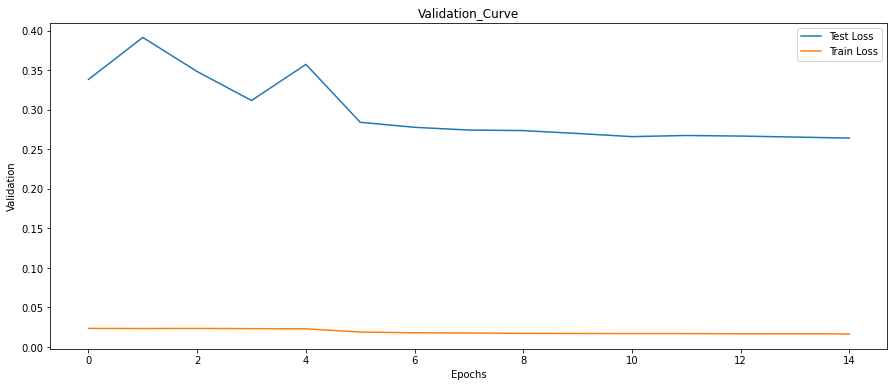

In [46]:
plot_graph(load_path=S2_PROJECT_PATH+'/Save_Model/'+name+'_stats.json', cols=["avg_test_loss","avg_train_loss"], legend_arr=['Test Loss', 'Train Loss'], xlabel='Epochs', ylabel='Validation', title='Validation_Curve', save_path=S2_PROJECT_PATH+'/Save_Model/')

In [47]:
# plot_graph(load_path=S2_PROJECT_PATH+'/Save_Model/'+name+'_stats.json', cols=["lr"], legend_arr="One-Cycle Learning Rate", xlabel='Epochs', ylabel='Learning Rate', title='One_Cycle_lr_Curve', save_path=S2_PROJECT_PATH+'/Save_Model/')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

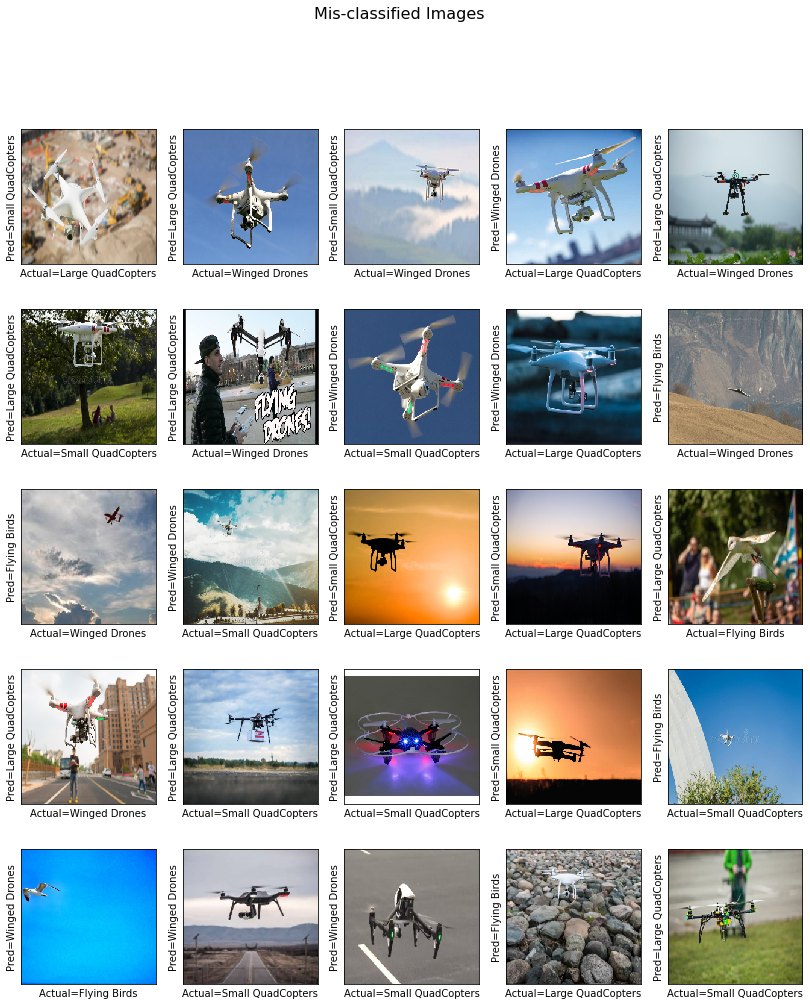

In [48]:
show_classified(MisClassifiedImages, MisClassifiedPredLabels, MisClassifiedTargLabels, le.classes_, mean, std,"Mis-classified Images",S2_PROJECT_PATH+'/Save_Model/',25)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

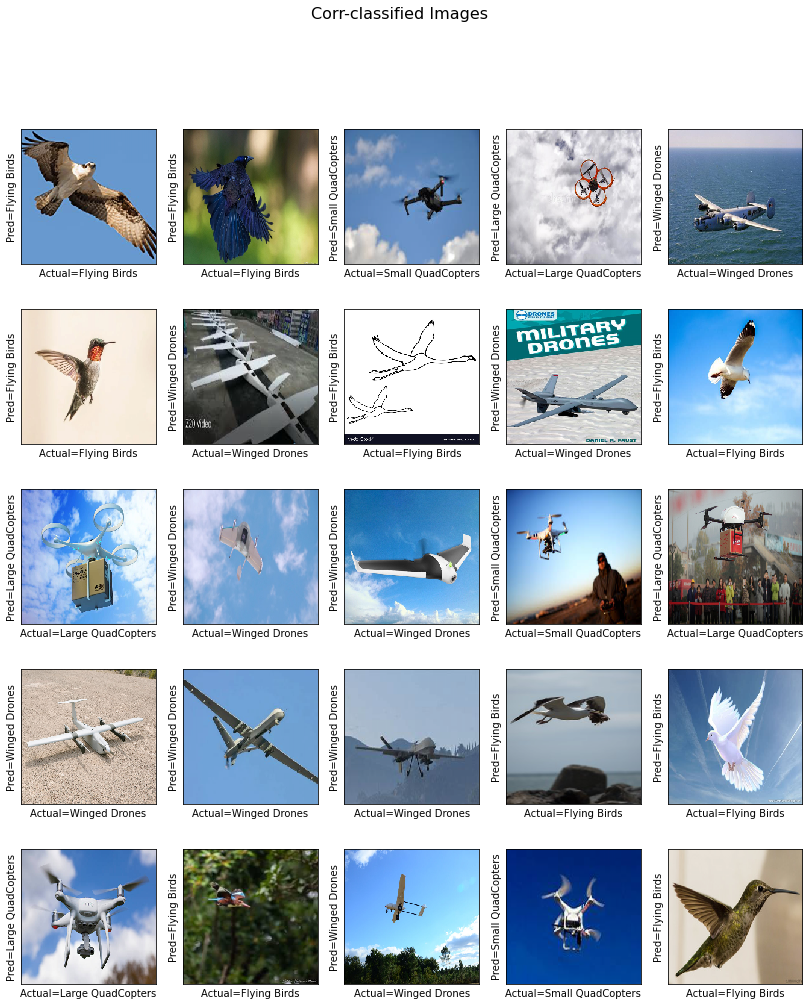

In [49]:
show_classified(CorrClassifiedImages, CorrClassifiedPredLabels, CorrClassifiedTargLabels, le.classes_, mean, std,"Corr-classified Images",S2_PROJECT_PATH+'/Save_Model/',25)

In [50]:
# layers for gradcam
for name, module in model.getmodel().named_modules():
  print(name)


features
features.0
features.0.0
features.0.1
features.0.2
features.1
features.1.conv
features.1.conv.0
features.1.conv.0.0
features.1.conv.0.1
features.1.conv.0.2
features.1.conv.1
features.1.conv.2
features.2
features.2.conv
features.2.conv.0
features.2.conv.0.0
features.2.conv.0.1
features.2.conv.0.2
features.2.conv.1
features.2.conv.1.0
features.2.conv.1.1
features.2.conv.1.2
features.2.conv.2
features.2.conv.3
features.3
features.3.conv
features.3.conv.0
features.3.conv.0.0
features.3.conv.0.1
features.3.conv.0.2
features.3.conv.1
features.3.conv.1.0
features.3.conv.1.1
features.3.conv.1.2
features.3.conv.2
features.3.conv.3
features.4
features.4.conv
features.4.conv.0
features.4.conv.0.0
features.4.conv.0.1
features.4.conv.0.2
features.4.conv.1
features.4.conv.1.0
features.4.conv.1.1
features.4.conv.1.2
features.4.conv.2
features.4.conv.3
features.5
features.5.conv
features.5.conv.0
features.5.conv.0.0
features.5.conv.0.1
features.5.conv.0.2
features.5.conv.1
features.5.conv.1.0

In [51]:
# Unlock layers for gradcam
gradcam_model = model.getmodel()
for param in gradcam_model.parameters():
    param.requires_grad = True

In [52]:
from GradCam import VisualizeCam
target_layers = ["features.4", "features.8", "features.12", "features.16"]
viz_cam = VisualizeCam(gradcam_model, le.classes_, target_layers)

torch.Size([25, 4])
Generating Grad-CAM @features.4
Generating Grad-CAM @features.8
Generating Grad-CAM @features.12
Generating Grad-CAM @features.16


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

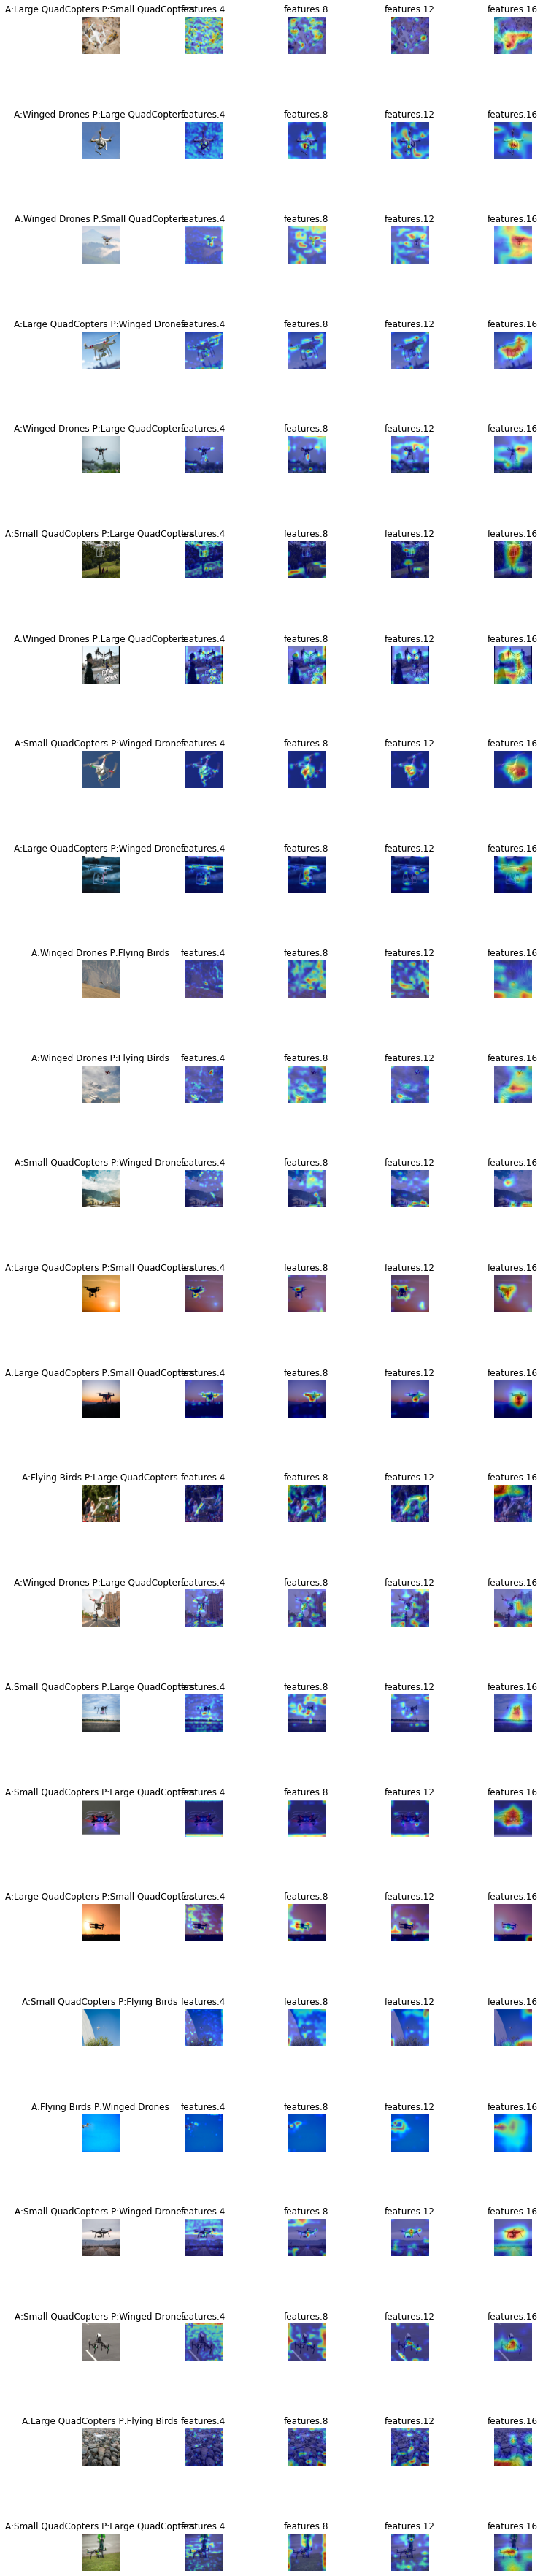

In [53]:
viz_cam(MisClassifiedImages[:25], MisClassifiedTargLabels[:25], target_layers, mean, std, target_inds=MisClassifiedTargLabels[:25], metric="Incorrect", per_image=False, path=S2_PROJECT_PATH+"/Save_Model/")

torch.Size([25, 4])
Generating Grad-CAM @features.4
Generating Grad-CAM @features.8
Generating Grad-CAM @features.12
Generating Grad-CAM @features.16


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

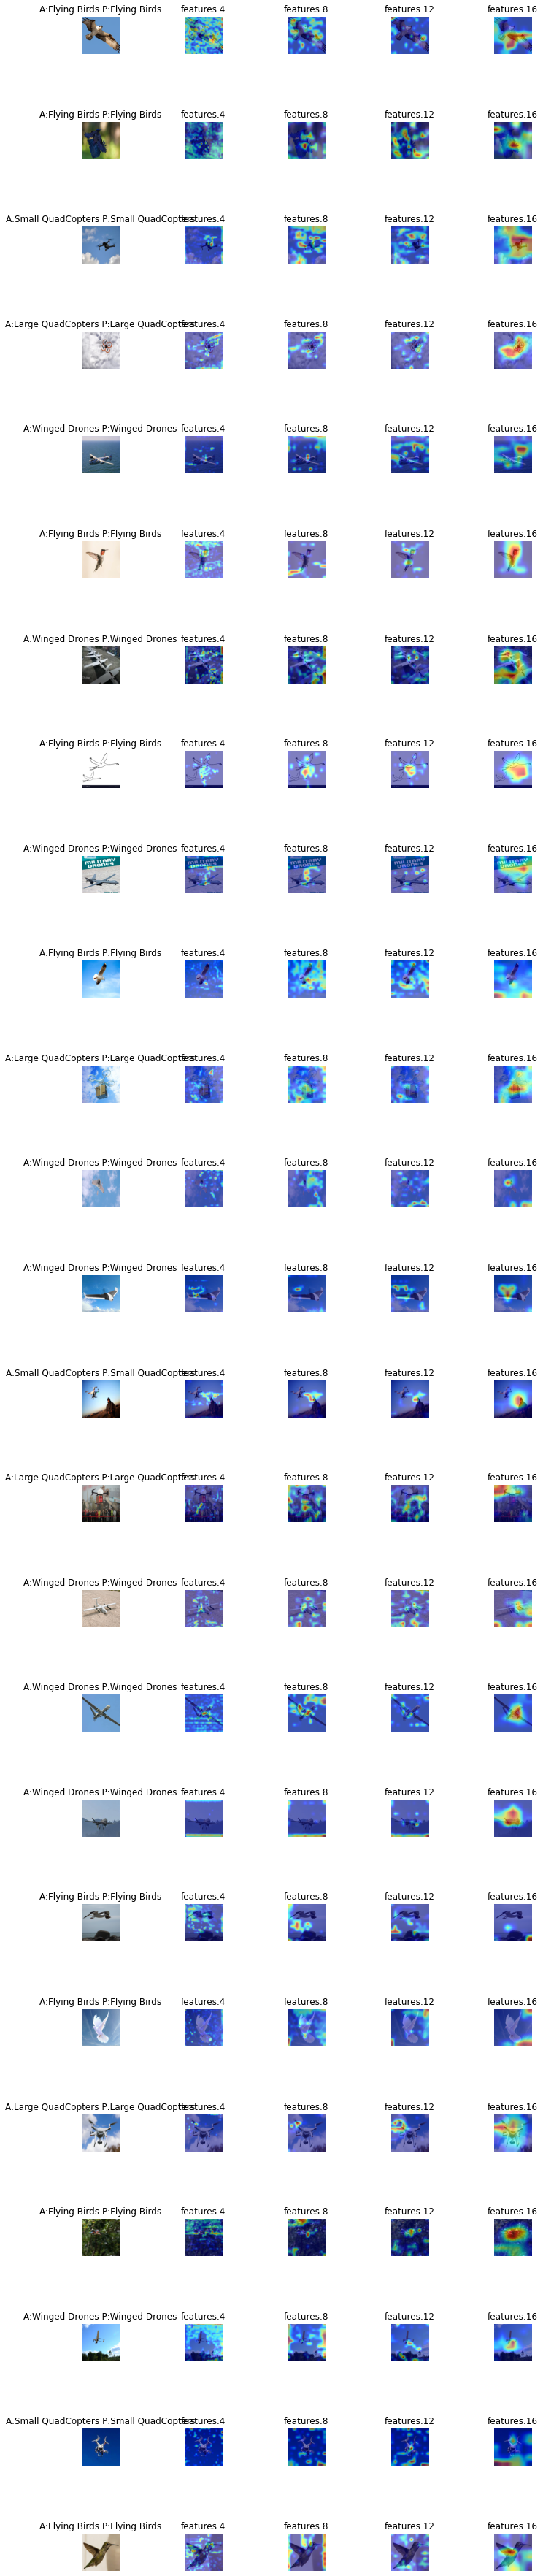

In [54]:
viz_cam(CorrClassifiedImages[:25], CorrClassifiedTargLabels[:25], target_layers, mean, std, target_inds=None, metric="Correct", per_image=False, path=S2_PROJECT_PATH+"/Save_Model/")

In [55]:
# %cp -av /content/tensorboard/ '{S2_PROJECT_PATH}/Save_Data/'

In [61]:
# Saving the model for deployment
jittracedmodel=model.getmodel()
jittracedmodel.to('cpu')
jittracedmodel.eval()
traced_model= torch.jit.trace(jittracedmodel, torch.randn(1,3,224,224))
traced_model.save(S2_PROJECT_PATH+"/Save_Model/S2_Mobilenet_traced.pt")